<a href="https://colab.research.google.com/github/Cecax27/DS-Stardew-Valley-Crops-Profit/blob/main/notebooks/Stardew_valley_analysis_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transform data

Previously, I extracted information from Stardew Valley Wiki about the crops and theirs seeds. You can see the notebook on: [Stardew_valley_web_scraper.ipynb](https://github.com/Cecax27/DS-Stardew-Valley-Crops-Profit/blob/main/notebooks/Stardew_valley_web_scraper.ipynb)

In this notebook I'll transform and clean the data to start to making analysis.

The url of the website is https://stardewvalleywiki.com. You can visit it to find a lot of information about the game.

## Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

In [ ]:
%matplotlib inline
sns.set_style(style='whitegrid')
sns.set_context(context='notebook')
plt.rcParams['figure.figsize'] = (7, 5)

## Loading data from csv

In [ ]:
df = pd.read_csv('crops_raw_data.csv')

print(f'DataFrame created with {df.shape[0]} rows and {df.shape[1]} columns\n')
print('Columns:')
print(df.dtypes)

DataFrame created with 43 rows and 26 columns

Columns:
Unnamed: 0                    int64
jojamart_price              float64
sell_prices_iridium         float64
night_market_price          float64
artisan_sell_price           object
name                         object
xp                           object
season                       object
general_store_price         float64
sell_price_regular          float64
traveling_cart_price_min    float64
source                       object
growth_time                  object
sell_prices_regular         float64
egg_festival_price          float64
traveling_cart_price_max    float64
sell_price_iridium          float64
base                         object
sell_prices_silver          float64
sell_price_silver           float64
description                  object
energy                       object
seed                         object
sell_prices_gold            float64
oasis_price                 float64
sell_price_gold             float64
dtype: o

## Transform data

Seeing the columns, I can start thinking about first modifications.

* I want to have the name column as the first. And the other ones ordered by alphabet.
* I have one column "sell_price_regular" and another "sell_prices_regular". The same for all the qualities. I will join both columns.
* I have in the column "season" a string with the seasons of each crop. I will divide the column in each season, like "spring", etc. And fill them with booleans values.

In [ ]:
# Ordering columns by alphabet
df = df.sort_index(axis=1)

# Changing 'name' column first
name_column = df.pop('name')
df.insert(0, 'name', name_column)

# Sorting the rows oby alphabet
df = df.sort_values('name')

In [ ]:
# Joining the sell_price columns
df['sell_price_regular'] = df['sell_price_regular'].combine_first(df['sell_prices_regular'])
df = df.drop('sell_prices_regular', axis=1)

df['sell_price_silver'] = df['sell_price_silver'].combine_first(df['sell_prices_silver'])
df = df.drop('sell_prices_silver', axis=1)

df['sell_price_gold'] = df['sell_price_gold'].combine_first(df['sell_prices_gold'])
df = df.drop('sell_prices_gold', axis=1)

df['sell_price_iridium'] = df['sell_price_iridium'].combine_first(df['sell_prices_iridium'])
df = df.drop('sell_prices_iridium', axis=1)

In [ ]:
# Creating separate columns for each season
seasons = ['Spring', 'Summer', 'Fall', 'Winter']
for season in seasons:
    df[season.lower()] = df['season'].str.contains(season, case=False)

# Fill the values with True or False
df = df.replace({True: 'True', False: 'False'})
df = df.drop('season', axis=1)

In [ ]:
print(f'DataFrame have {df.shape[0]} rows and {df.shape[1]} columns\n')
print('Columns:')
print(df.dtypes)

DataFrame have 43 rows and 25 columns

Columns:
name                         object
Unnamed: 0                    int64
artisan_sell_price           object
base                         object
description                  object
egg_festival_price          float64
energy                       object
general_store_price         float64
growth_time                  object
jojamart_price              float64
night_market_price          float64
oasis_price                 float64
seed                         object
sell_price_gold             float64
sell_price_iridium          float64
sell_price_regular          float64
sell_price_silver           float64
source                       object
traveling_cart_price_max    float64
traveling_cart_price_min    float64
xp                           object
spring                       object
summer                       object
fall                         object
winter                       object
dtype: object


## Cleaning data

In [ ]:
# Wich columns have null values?
(
    df
    .isnull()
    .sum()
)

name                         0
Unnamed: 0                   0
artisan_sell_price          42
base                         4
description                  0
egg_festival_price          42
energy                      36
general_store_price         14
growth_time                  0
jojamart_price              19
night_market_price          35
oasis_price                 40
seed                         2
sell_price_gold              2
sell_price_iridium           2
sell_price_regular           1
sell_price_silver            2
source                      39
traveling_cart_price_max     7
traveling_cart_price_min     7
xp                           2
spring                       2
summer                       2
fall                         2
winter                       2
dtype: int64

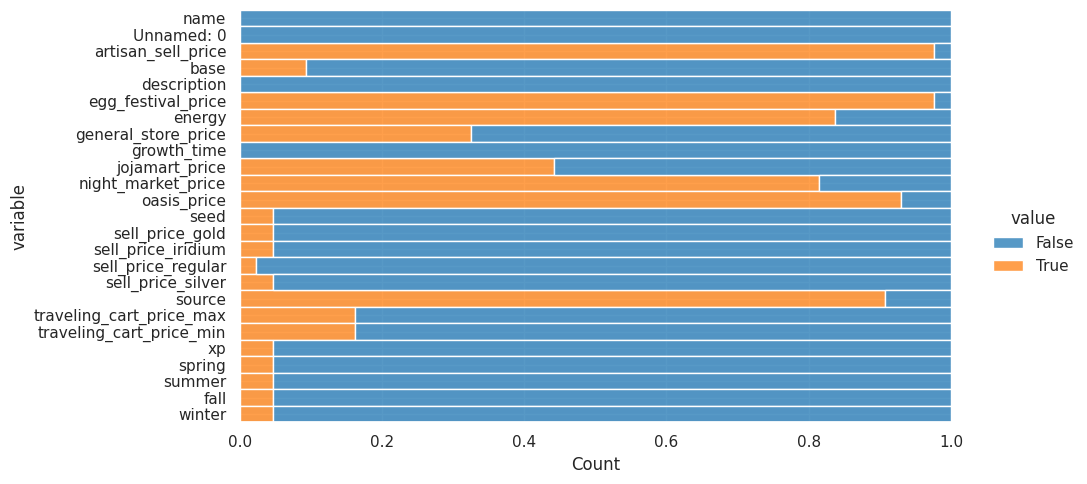

In [ ]:
# Null values proportion for each variable
(
    df
    .isnull()
    .melt()
    .pipe(
        lambda df: (
            sns.displot(
                data = df,
                y = 'variable',
                hue = 'value',
                multiple = 'fill',
                aspect = 2
            )
        )
    )
)

In [ ]:
df.describe(include = 'all')

,name,Unnamed: 0,artisan_sell_price,base,description,egg_festival_price,energy,general_store_price,growth_time,jojamart_price,...,sell_price_regular,sell_price_silver,source,traveling_cart_price_max,traveling_cart_price_min,xp,spring,summer,fall,winter
count,43,43.000000,1,39,43,1.0,7,29.000000,43.000000,24.000000,...,42.000000,41.000000,4,36.000000,36.000000,41,41,41,41,41
unique,43,NaN,1,1,43,NaN,1,NaN,NaN,NaN,...,NaN,NaN,4,NaN,NaN,31,2,2,2,1
top,Amaranth,NaN,150g,Artisan (+40%),A purple grain cultivated by an ancient civili...,NaN,Inedible,NaN,NaN,NaN,...,NaN,NaN,Foraging in the Desert\nOasis\n Cactus Seeds,NaN,NaN,14 Farming XP,False,False,False,False
freq,1,NaN,1,39,1,NaN,7,NaN,NaN,NaN,...,NaN,NaN,1,NaN,NaN,3,27,22,25,41
mean,NaN,21.000000,NaN,NaN,NaN,100.0,NaN,73.793103,9.348837,90.958333,...,200.619048,255.097561,NaN,1041.666667,187.222222,NaN,NaN,NaN,NaN,NaN
std,NaN,12.556539,NaN,NaN,NaN,NaN,NaN,57.159788,5.406714,69.644738,...,465.428203,588.279262,NaN,250.000000,254.312643,NaN,NaN,NaN,NaN,NaN
min,NaN,0.000000,NaN,NaN,NaN,100.0,NaN,10.000000,0.000000,12.000000,...,1.000000,1.000000,NaN,1000.000000,100.000000,NaN,NaN,NaN,NaN,NaN
25%,NaN,10.500000,NaN,NaN,NaN,100.0,NaN,40.000000,6.000000,50.000000,...,50.000000,62.000000,NaN,1000.000000,100.000000,NaN,NaN,NaN,NaN,NaN
50%,NaN,21.000000,NaN,NaN,NaN,100.0,NaN,60.000000,8.000000,75.000000,...,80.000000,100.000000,NaN,1000.000000,100.000000,NaN,NaN,NaN,NaN,NaN
75%,NaN,31.500000,NaN,NaN,NaN,100.0,NaN,80.000000,12.000000,106.250000,...,160.000000,200.000000,NaN,1000.000000,150.000000,NaN,NaN,NaN,NaN,NaN


In [ ]:
(
    df
    .species
    .value_counts()
    .plot(
        kind = 'bar'
    )
)

In [ ]:
df['growth_time'] = (
    df
    .growth_time
    .fillna('0')
    .apply(lambda i: i.split(' ')[0])
    .astype(int)
)

In [ ]:
df.to_csv('crops.csv')

**Deleting the Ginger Island crops**

I deleted the Ginger Island crops because you can't buy the seed in the stores. You can trade they but it's more difficult to compare the price of the trade with gold. The Ginger Island crops are:

* Taro roots
* Pineapple

Also, I deleted some crops in similar situations, like:

* Tea Leaves
* Sweet Gem Berry
* Mixed Seeds
* Fiber
* Cactus Fruit
* Strawberry
* Coffee Bean




In [ ]:
df = df.drop(df[df['name'] == 'Taro Root'].index)
df = df.drop(df[df['name'] == 'Pineapple'].index)

df = df.drop(df[df['name'] == 'Tea Leaves'].index)
df = df.drop(df[df['name'] == 'Sweet Gem Berry'].index)
df = df.drop(df[df['name'] == 'Mixed Seeds'].index)
df = df.drop(df[df['name'] == 'Fiber'].index)
df = df.drop(df[df['name'] == 'Cactus Fruit'].index)
df = df.drop(df[df['name'] == 'Strawberry'].index)
df = df.drop(df[df['name'] == 'Coffee Bean'].index)

In [ ]:
df['price_min'] = df[['night_market_price', 'oasis_price', 'general_store_price', 'jojamart_price', 'traveling_cart_price_min']].min(axis=1)

In [ ]:
df[['name', 'sell_price_regular', 'growth_time', 'price_min']].head()

In [ ]:
df['gold_per_day'] = ( df['sell_price_iridium'] - df['price_min'])  / df['growth_time']

In [ ]:
df[df['spring'] == 'True'][['name', 'sell_price_iridium', 'growth_time', 'price_min', 'gold_per_day']].sort_values('gold_per_day', ascending = False)